In [88]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

In [89]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [90]:
#for more info on how this mask works, see https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py
all_basins = xmitgcm.utils.read_3d_llc_data('/home/jovyan/basins.data', nx=90,nz=1,nrecs=1,dtype='>f')
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [91]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [92]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [93]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [94]:
#Makes array of total volume transport above sigma=102 in the basin as a function of time
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, 212, :].sum('l3_c') #at j_g = 215, up to sigma = 102
volume_over_time = tr.sum('i') 

In [9]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:180] - volume_over_time 
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) #largest, time dimension
istar1 = istar_over_time + 110

In [95]:
#Ensure that the total volume at istar is the total volume on top of the band 
#volume at istar
volume_at_istar = tr.where(tr.i < istar1).sum('i')

In [96]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, 212, :] #(time, l3_c, i)

In [97]:
#top left and right
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])

adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])

bottom = a[:, 101:, :].sum(['l3_c', 'i'])

nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 

In [71]:
#Compute the next cell's advection - top left  
adv_nextcell = a.where(a.i < istar3)[:, :101, :].sum(['i','l3_c'])
adv_difference = adv_nextcell - top_left 
adv_topleft = ((ratio * adv_difference + top_left)*ds.dt).cumsum('time')

In [72]:
#top right 
adv_nextcell = a.where(a.i >= istar3)[:, :101, :].sum(['i','l3_c']) 
adv_difference = adv_nextcell - top_right
adv_topright = ((ratio*adv_difference + top_right) * ds.dt).cumsum('time')

In [77]:
#bottom
bottom = ((a[:, 101:, :].sum(['l3_c', 'i'])) * ds.dt).cumsum('time')

In [78]:
#Load
adv_topright.load()

<xarray.DataArray (time: 288)>
array([ 0.00000000e+00, -1.12118435e+20, -1.12051776e+20, -1.58694157e+20,
       -1.79476545e+20, -2.84668373e+20, -4.32033431e+20, -6.15654639e+20,
       -6.71918320e+20, -8.43946417e+20, -1.06377094e+21, -1.27864473e+21,
       -1.45515754e+21, -1.50079090e+21, -1.56580228e+21, -1.56773534e+21,
       -1.62432178e+21, -1.70216103e+21, -1.75616366e+21, -1.90741048e+21,
       -2.09151275e+21, -2.29293793e+21, -2.41971008e+21, -2.44691747e+21,
       -2.54600329e+21, -2.79153191e+21, -2.85742446e+21, -2.83901144e+21,
       -2.84403306e+21, -2.82161645e+21, -2.82969483e+21, -2.98291545e+21,
       -3.14560461e+21, -3.34649927e+21, -3.64157667e+21, -3.74815526e+21,
       -3.84981994e+21, -3.94619047e+21, -3.93121071e+21, -4.07045448e+21,
       -4.20163046e+21, -4.21500223e+21, -4.37898363e+21, -4.56382400e+21,
       -4.67327592e+21, -4.86934643e+21, -5.13573564e+21, -5.49769990e+21,
       -5.71707645e+21, -5.75464008e+21, -5.87784818e+21, -6.02848048e+21,
       -6.11819680e+21, -6.15652635e+21, -6.19944196e+21, -6.36037820e+21,
       -6.63788145e+21, -6.85829813e+21, -6.97053652e+21, -7.19931758e+21,
       -7.41220218e+21, -7.51512106e+21, -7.65625221e+21, -7.80636312e+21,
       -7.89581553e+21, -8.03532818e+21, -8.18501438e+21, -8.43648550e+21,
       -8.58731254e+21, -9.00585002e+21, -9.44389817e+21, -9.84266091e+21,
       -1.00212453e+22, -1.01983974e+22, -1.03430470e+22, -1.03980202e+22,
       -1.04586351e+22, -1.06137881e+22, -1.08239444e+22, -1.10496215e+22,
       -1.13988986e+22, -1.17214585e+22, -1.20060238e+22, -1.23002353e+22,
       -1.23685497e+22, -1.24570211e+22, -1.25728824e+22, -1.27475186e+22,
       -1.28008336e+22, -1.28556837e+22, -1.30626243e+22, -1.33616638e+22,
       -1.36127253e+22, -1.38819855e+22, -1.40352280e+22, -1.41904248e+22,
       -1.43240829e+22, -1.43908020e+22, -1.45135448e+22, -1.45960985e+22,
       -1.46648174e+22, -1.47124710e+22, -1.48143263e+22, -1.49397615e+22,
       -1.50832906e+22, -1.51829712e+22, -1.55255692e+22, -1.59830685e+22,
       -1.62114873e+22, -1.63252871e+22, -1.64800220e+22, -1.65363086e+22,
       -1.65804459e+22, -1.66309668e+22, -1.67193585e+22, -1.69108497e+22,
       -1.70862484e+22, -1.73265586e+22, -1.74046525e+22, -1.76989874e+22,
       -1.80070354e+22, -1.80670703e+22, -1.81090676e+22, -1.81458445e+22,
       -1.81348194e+22, -1.81547197e+22, -1.82559551e+22, -1.84117466e+22,
       -1.86350962e+22, -1.88775060e+22, -1.91866437e+22, -1.95717214e+22,
       -1.97751051e+22, -1.98984309e+22, -1.99905445e+22, -2.00926910e+22,
       -2.01311841e+22, -2.02604281e+22, -2.04283094e+22, -2.06975854e+22,
       -2.08855901e+22, -2.10562257e+22, -2.12924935e+22, -2.15582557e+22,
       -2.19208927e+22, -2.21580419e+22, -2.22689629e+22, -2.23630155e+22,
       -2.24583116e+22, -2.26201503e+22, -2.27653941e+22, -2.30478085e+22,
       -2.32045280e+22, -2.34807554e+22, -2.37089749e+22, -2.38370046e+22,
       -2.39721298e+22, -2.41155737e+22, -2.44332457e+22, -2.45642858e+22,
       -2.46776330e+22, -2.48283208e+22, -2.50060335e+22, -2.52393438e+22,
       -2.54588155e+22, -2.58742788e+22, -2.60719594e+22, -2.63725484e+22,
       -2.65819100e+22, -2.67808388e+22, -2.70711557e+22, -2.72375754e+22,
       -2.73675198e+22, -2.75292606e+22, -2.78218233e+22, -2.81243015e+22,
       -2.85048863e+22, -2.89198050e+22, -2.91420405e+22, -2.94252152e+22,
       -2.96493865e+22, -2.99154952e+22, -3.00172840e+22, -3.01791909e+22,
       -3.02484990e+22, -3.04190032e+22, -3.05469689e+22, -3.07211067e+22,
       -3.09567957e+22, -3.12088686e+22, -3.13786135e+22, -3.16392524e+22,
       -3.17974326e+22, -3.19855153e+22, -3.21516402e+22, -3.22845198e+22,
       -3.24366149e+22, -3.25905611e+22, -3.27169673e+22, -3.29248874e+22,
       -3.30445580e+22, -3.32490369e+22, -3.32816697e+22, -3.34081117e+22,
       -3.36763218e+22, -3.38367791e+22, -3.38730652e+22, -3.38769052e+22,
       -3.38485569e+22, -3.39477110e+22, -3.40657871e+22, -3.41555958

In [79]:
adv_topleft.load()

<xarray.DataArray (time: 288)>
array([0.00000000e+00, 1.60491563e+21, 3.36354812e+21, 4.94534410e+21,
       7.16830755e+21, 9.38264887e+21, 1.15497421e+22, 1.38689250e+22,
       1.64922493e+22, 1.89958184e+22, 2.08525228e+22, 2.29664979e+22,
       2.46675592e+22, 2.69743004e+22, 2.90036572e+22, 3.10566941e+22,
       3.32148704e+22, 3.53555846e+22, 3.78075230e+22, 4.03206912e+22,
       4.27363988e+22, 4.54256827e+22, 4.78003177e+22, 4.99539072e+22,
       5.15937893e+22, 5.23858202e+22, 5.43347509e+22, 5.65047497e+22,
       5.85526315e+22, 6.10090004e+22, 6.34077289e+22, 6.57688291e+22,
       6.81926268e+22, 7.07951778e+22, 7.27422818e+22, 7.49325786e+22,
       7.68589258e+22, 7.83215168e+22, 8.06176149e+22, 8.24511739e+22,
       8.43558429e+22, 8.70512076e+22, 8.95738825e+22, 9.21157117e+22,
       9.48918440e+22, 9.76579265e+22, 1.00284683e+23, 1.01917053e+23,
       1.03454912e+23, 1.05584693e+23, 1.07614820e+23, 1.09624541e+23,
       1.12305337e+23, 1.14792186e+23, 1.17556559e+23, 1.20267668e+23,
       1.22803537e+23, 1.25477266e+23, 1.28048309e+23, 1.30576982e+23,
       1.32838553e+23, 1.34452907e+23, 1.36553224e+23, 1.38659056e+23,
       1.41005724e+23, 1.43617109e+23, 1.46354675e+23, 1.49203914e+23,
       1.52411149e+23, 1.55278432e+23, 1.56916512e+23, 1.58656294e+23,
       1.61056291e+23, 1.64007158e+23, 1.66479744e+23, 1.68416642e+23,
       1.71261280e+23, 1.73726252e+23, 1.76369003e+23, 1.79404315e+23,
       1.82120652e+23, 1.84983926e+23, 1.87821190e+23, 1.89850209e+23,
       1.92442908e+23, 1.94857887e+23, 1.97292855e+23, 1.99134492e+23,
       2.01867076e+23, 2.04636709e+23, 2.07230056e+23, 2.09877266e+23,
       2.12732752e+23, 2.15378835e+23, 2.18563921e+23, 2.20957515e+23,
       2.23428173e+23, 2.25549367e+23, 2.28262459e+23, 2.30372768e+23,
       2.33068215e+23, 2.35402770e+23, 2.37985080e+23, 2.40679323e+23,
       2.43382118e+23, 2.46057799e+23, 2.47774430e+23, 2.49000709e+23,
       2.50380506e+23, 2.52088986e+23, 2.53591020e+23, 2.55540544e+23,
       2.58100930e+23, 2.60548367e+23, 2.63028395e+23, 2.65749516e+23,
       2.68928007e+23, 2.71775728e+23, 2.75257507e+23, 2.78127157e+23,
       2.79549775e+23, 2.81617731e+23, 2.83832426e+23, 2.86165826e+23,
       2.88299990e+23, 2.90665546e+23, 2.93160179e+23, 2.95977064e+23,
       2.98818213e+23, 3.01630006e+23, 3.03294045e+23, 3.04972466e+23,
       3.06789856e+23, 3.08228953e+23, 3.10710882e+23, 3.13175747e+23,
       3.15852821e+23, 3.18170880e+23, 3.20736864e+23, 3.23574895e+23,
       3.26717367e+23, 3.30050547e+23, 3.32478356e+23, 3.35039148e+23,
       3.36491315e+23, 3.38498473e+23, 3.40663623e+23, 3.43124786e+23,
       3.45882098e+23, 3.48458867e+23, 3.51256831e+23, 3.54172698e+23,
       3.57294210e+23, 3.60541485e+23, 3.63716240e+23, 3.66589006e+23,
       3.69221790e+23, 3.72109941e+23, 3.74067221e+23, 3.76594379e+23,
       3.79157038e+23, 3.81811846e+23, 3.84669383e+23, 3.87811272e+23,
       3.90764817e+23, 3.93459949e+23, 3.96660343e+23, 3.99559942e+23,
       4.01759458e+23, 4.03557968e+23, 4.05145493e+23, 4.07873392e+23,
       4.10506748e+23, 4.13450612e+23, 4.16234018e+23, 4.19366803e+23,
       4.22030308e+23, 4.24833482e+23, 4.28065286e+23, 4.30195868e+23,
       4.32512821e+23, 4.33691342e+23, 4.35854573e+23, 4.38277190e+23,
       4.40718542e+23, 4.43052816e+23, 4.45511411e+23, 4.48336516e+23,
       4.51310002e+23, 4.54358913e+23, 4.57477794e+23, 4.59573256e+23,
       4.61720407e+23, 4.63882401e+23, 4.66096204e+23, 4.68543058e+23,
       4.70882195e+23, 4.73343850e+23, 4.76014498e+23, 4.78450464e+23,
       4.81677099e+23, 4.84378988e+23, 4.87465655e+23, 4.89688424e+23,
       4.90956767e+23, 4.92476420e+23, 4.95136053e+23, 4.97169465e+23,
       4.99644888e+23, 5.02041589e+23, 5.04519245e+23, 5.07145126e+23,
       5.10035196e+23, 5.12426722e+23, 5.14692913e+23, 5.16520019e+23,
       5.18478979e+23, 5.19855799e+23, 5.22283402e+23, 5.24757583e+23,
       5.26944856e+23, 5.29180933e+23, 5.31831400e+23, 5.3463052

In [80]:
bottom.load()

<xarray.DataArray (time: 288)>
array([ 0.00000000e+00, -6.14716439e+20, -1.29392019e+21, -1.89276478e+21,
       -2.59417238e+21, -3.25506859e+21, -3.92842029e+21, -4.55189419e+21,
       -5.21454649e+21, -5.84719595e+21, -6.39691895e+21, -6.94000422e+21,
       -7.50758352e+21, -8.17619346e+21, -8.75801308e+21, -9.44839690e+21,
       -1.01499520e+22, -1.07844148e+22, -1.14870441e+22, -1.21686287e+22,
       -1.27755649e+22, -1.34732772e+22, -1.41035488e+22, -1.47941570e+22,
       -1.54241833e+22, -1.57940991e+22, -1.64281582e+22, -1.70885067e+22,
       -1.77452562e+22, -1.84236959e+22, -1.91262927e+22, -1.97996291e+22,
       -2.04286568e+22, -2.11420605e+22, -2.16780787e+22, -2.23039615e+22,
       -2.29592647e+22, -2.35146345e+22, -2.42338647e+22, -2.48372331e+22,
       -2.55621661e+22, -2.63163237e+22, -2.70231000e+22, -2.77005703e+22,
       -2.84085126e+22, -2.91677559e+22, -2.98109107e+22, -3.03681809e+22,
       -3.09049670e+22, -3.16230189e+22, -3.22839542e+22, -3.29463681e+22,
       -3.37442439e+22, -3.45072290e+22, -3.52741115e+22, -3.60527987e+22,
       -3.66540183e+22, -3.73805395e+22, -3.80673311e+22, -3.86909040e+22,
       -3.93307248e+22, -3.99358392e+22, -4.06694172e+22, -4.14163144e+22,
       -4.22672311e+22, -4.30384348e+22, -4.38402181e+22, -4.45949889e+22,
       -4.54254804e+22, -4.61572574e+22, -4.66499914e+22, -4.72246499e+22,
       -4.79451463e+22, -4.87302189e+22, -4.95164223e+22, -5.02620282e+22,
       -5.11616242e+22, -5.19297559e+22, -5.27028205e+22, -5.34926645e+22,
       -5.42168397e+22, -5.49873747e+22, -5.57486889e+22, -5.64375065e+22,
       -5.72024766e+22, -5.79685774e+22, -5.87381057e+22, -5.94203928e+22,
       -6.02407379e+22, -6.10393343e+22, -6.18108407e+22, -6.25903835e+22,
       -6.33045752e+22, -6.39975906e+22, -6.47518443e+22, -6.54552588e+22,
       -6.61362501e+22, -6.68339266e+22, -6.76431533e+22, -6.83094190e+22,
       -6.91563745e+22, -6.98892302e+22, -7.06041550e+22, -7.13540215e+22,
       -7.20661003e+22, -7.27933039e+22, -7.33128555e+22, -7.37889833e+22,
       -7.43191062e+22, -7.49224942e+22, -7.54708831e+22, -7.61647944e+22,
       -7.69629932e+22, -7.76811504e+22, -7.84179696e+22, -7.91152264e+22,
       -7.98211765e+22, -8.05305898e+22, -8.13249148e+22, -8.20194620e+22,
       -8.25417667e+22, -8.32128052e+22, -8.39158477e+22, -8.46809225e+22,
       -8.54673896e+22, -8.62219139e+22, -8.69695023e+22, -8.76889512e+22,
       -8.83480892e+22, -8.90063656e+22, -8.94848376e+22, -8.99827927e+22,
       -9.06853154e+22, -9.11973629e+22, -9.19342466e+22, -9.26620266e+22,
       -9.35135175e+22, -9.42367441e+22, -9.49578479e+22, -9.56903588e+22,
       -9.64655475e+22, -9.71662403e+22, -9.78268677e+22, -9.85459173e+22,
       -9.91550262e+22, -9.97919283e+22, -1.00521008e+23, -1.01276993e+23,
       -1.02137392e+23, -1.02890827e+23, -1.03656700e+23, -1.04415449e+23,
       -1.05196928e+23, -1.05996066e+23, -1.06822812e+23, -1.07627349e+23,
       -1.08400061e+23, -1.09166739e+23, -1.09803770e+23, -1.10575967e+23,
       -1.11393808e+23, -1.12184027e+23, -1.12970998e+23, -1.13751063e+23,
       -1.14540999e+23, -1.15259486e+23, -1.16018548e+23, -1.16744576e+23,
       -1.17416341e+23, -1.18040990e+23, -1.18648022e+23, -1.19445324e+23,
       -1.20266118e+23, -1.21007712e+23, -1.21764397e+23, -1.22527162e+23,
       -1.23217086e+23, -1.23972256e+23, -1.24742981e+23, -1.25467231e+23,
       -1.26208047e+23, -1.26756533e+23, -1.27490198e+23, -1.28304619e+23,
       -1.29057950e+23, -1.29812353e+23, -1.30560102e+23, -1.31358248e+23,
       -1.32105800e+23, -1.32917572e+23, -1.33660725e+23, -1.34343498e+23,
       -1.35053204e+23, -1.35674515e+23, -1.36449170e+23, -1.37184174e+23,
       -1.37987661e+23, -1.38754156e+23, -1.39542637e+23, -1.40310432e+23,
       -1.41075892e+23, -1.41837805e+23, -1.42582530e+23, -1.43258186e+23,
       -1.43791439e+23, -1.44359184e+23, -1.45154824e+23, -1.45865808e+23,
       -1.46657905e+23, -1.47338878e+23, -1.48107732e+23, -1.48843149

In [81]:
#detrending
right_detrend = xr.apply_ufunc(detrend, adv_topright.load().fillna(0),kwargs={'axis': 0}).where(~adv_topright.isnull())
left_detrend= xr.apply_ufunc(detrend, adv_topleft.load().fillna(0),kwargs={'axis': 0}).where(~adv_topleft.isnull())
bottom_detrend = xr.apply_ufunc(detrend, bottom.load().fillna(0),kwargs={'axis': 0}).where(~bottom.isnull())

#remove season
#Removing seasons 
right_month = right_detrend.groupby('time.month').mean('time')
left_month = left_detrend.groupby('time.month').mean('time')
bottom_month = bottom_detrend.groupby('time.month').mean('time')

right_ds = right_detrend.groupby('time.month') - right_month
left_ds = left_detrend.groupby('time.month') - left_month
bottom_ds = bottom_detrend.groupby('time.month') - bottom_month

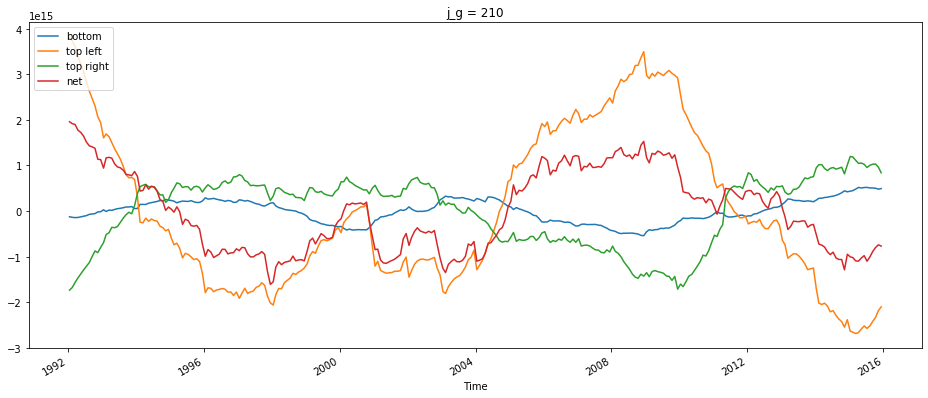

In [42]:
#detrend, mean removed
net = bottom_ds + left_ds+ right_ds
fig, ax = pltt.subplots(figsize=(16,6))
(bottom_ds).plot(ax=ax)
(left_ds).plot(ax=ax)
(right_ds).plot(ax=ax)
(net).plot(ax=ax)
ax.legend(("bottom", "top left", "top right", "net"),loc='upper left')

In [82]:
#Piecuch's throughflow 

v = (ds.VVELMASS[:, :, 212, :] * coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
t = (THETA_jg[:, :, 212, :] * coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
a = (coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :] * coords.hFacS[:, 212, :]).sum(['i','k'])
p_throughflow = (v*t*ds.dt).cumsum('time') / a #has units of degCm^3/s- should i do a minus (v*t[time 0])? 
p_throughflow.load()

<xarray.DataArray (time: 288)>
array([ 0.00000000e+00, -3.07007119e+13, -6.01167390e+13, -8.92512198e+13,
       -1.20780049e+14, -1.63606433e+14, -2.00717830e+14, -2.23343669e+14,
       -2.30432019e+14, -2.59210564e+14, -2.80918039e+14, -2.96784030e+14,
       -3.29665438e+14, -3.66184350e+14, -3.80282399e+14, -4.20497263e+14,
       -4.63511302e+14, -4.96323800e+14, -5.34161308e+14, -5.65399042e+14,
       -5.86783669e+14, -6.19714999e+14, -6.33320185e+14, -6.58783192e+14,
       -6.99673384e+14, -7.31399701e+14, -7.43331266e+14, -7.64540900e+14,
       -7.99074654e+14, -8.25390917e+14, -8.61994555e+14, -8.98910001e+14,
       -9.02982364e+14, -9.17422520e+14, -9.29262912e+14, -9.44498918e+14,
       -9.73665888e+14, -1.00104551e+15, -1.02785436e+15, -1.05699637e+15,
       -1.10211931e+15, -1.13683794e+15, -1.17516850e+15, -1.20109589e+15,
       -1.23620768e+15, -1.26498522e+15, -1.29378631e+15, -1.31848498e+15,
       -1.35351523e+15, -1.38189703e+15, -1.42350436e+15, -1.44692783e+15,
       -1.48228137e+15, -1.51110018e+15, -1.54061464e+15, -1.57849374e+15,
       -1.59189783e+15, -1.62342865e+15, -1.65935088e+15, -1.68005872e+15,
       -1.69834584e+15, -1.72165805e+15, -1.75245015e+15, -1.77739498e+15,
       -1.82776040e+15, -1.87139870e+15, -1.90481077e+15, -1.93376763e+15,
       -1.95121839e+15, -1.97254594e+15, -2.00363097e+15, -2.01890707e+15,
       -2.04364101e+15, -2.07492431e+15, -2.10749488e+15, -2.14394332e+15,
       -2.17783233e+15, -2.21548075e+15, -2.24862617e+15, -2.27378088e+15,
       -2.30759078e+15, -2.34021266e+15, -2.37145297e+15, -2.39622255e+15,
       -2.41063418e+15, -2.43588765e+15, -2.46079676e+15, -2.48559092e+15,
       -2.51457565e+15, -2.54516171e+15, -2.58685248e+15, -2.62879978e+15,
       -2.63886116e+15, -2.65474886e+15, -2.67080612e+15, -2.68849292e+15,
       -2.69577247e+15, -2.72936736e+15, -2.75999145e+15, -2.78475329e+15,
       -2.81745433e+15, -2.84740268e+15, -2.87399046e+15, -2.90041856e+15,
       -2.91117567e+15, -2.92182042e+15, -2.95521840e+15, -2.99898792e+15,
       -3.01032109e+15, -3.06166468e+15, -3.07871217e+15, -3.10949719e+15,
       -3.13208434e+15, -3.15898222e+15, -3.18658626e+15, -3.19573688e+15,
       -3.21219374e+15, -3.21923966e+15, -3.24136968e+15, -3.24853736e+15,
       -3.26014410e+15, -3.29160788e+15, -3.33419811e+15, -3.36669603e+15,
       -3.39657302e+15, -3.42090060e+15, -3.44155812e+15, -3.44906113e+15,
       -3.45551160e+15, -3.46373526e+15, -3.48050181e+15, -3.49892148e+15,
       -3.53929094e+15, -3.54100862e+15, -3.57081354e+15, -3.60802308e+15,
       -3.64233996e+15, -3.67515680e+15, -3.69195437e+15, -3.71203773e+15,
       -3.72757492e+15, -3.74241384e+15, -3.76074585e+15, -3.78529729e+15,
       -3.82589251e+15, -3.85654072e+15, -3.88379012e+15, -3.92586117e+15,
       -3.96931689e+15, -4.00625432e+15, -4.03575310e+15, -4.07514899e+15,
       -4.09381750e+15, -4.12817245e+15, -4.15860944e+15, -4.17828293e+15,
       -4.21483638e+15, -4.23020907e+15, -4.26237455e+15, -4.29334914e+15,
       -4.32797290e+15, -4.37016235e+15, -4.40695386e+15, -4.44208620e+15,
       -4.48000042e+15, -4.49682272e+15, -4.50934632e+15, -4.51116085e+15,
       -4.51811003e+15, -4.55467552e+15, -4.58709544e+15, -4.60832230e+15,
       -4.64287643e+15, -4.66751307e+15, -4.70354670e+15, -4.73486540e+15,
       -4.75903333e+15, -4.78957987e+15, -4.81320505e+15, -4.83239002e+15,
       -4.85618789e+15, -4.90463212e+15, -4.91550044e+15, -4.94336558e+15,
       -4.97584321e+15, -5.01747536e+15, -5.05431987e+15, -5.09104971e+15,
       -5.12331512e+15, -5.14753890e+15, -5.17383690e+15, -5.21099995e+15,
       -5.23451963e+15, -5.24445375e+15, -5.27092708e+15, -5.30540234e+15,
       -5.33435256e+15, -5.36380973e+15, -5.39833150e+15, -5.43022903e+15,
       -5.44602641e+15, -5.45629943e+15, -5.48269533e+15, -5.50429996e+15,
       -5.51254877e+15, -5.54051207e+15, -5.57052845e+15, -5.59494306e+15,
       -5.62600255e+15, -5.66230508e+15, -5.71535275e+15, -5.73510829

In [83]:
#Overturning
v = (ds.VVELMASS[:, :, 212, :] * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum('i')
t = (THETA_jg[:, :, 212, :] * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum('i')
a = (coords.dxG[212, :] * ds.atl_maskS[212, :] * coords.hFacS[:, 212, :]).sum('i')
ov1 = (((v * t * coords.drF)/a).sum('k')) * ds.dt 
ov = ov1.cumsum('time')
p_overturning = ov - p_throughflow  #also has units of degCm^3/s
p_overturning.load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (time: 288)>
array([0.00000000e+00, 1.97871618e+14, 4.41949363e+14, 6.26983302e+14,
       8.93143100e+14, 1.13416751e+15, 1.33946616e+15, 1.57188308e+15,
       1.88324256e+15, 2.17430617e+15, 2.35088945e+15, 2.61068193e+15,
       2.80502869e+15, 3.12832561e+15, 3.39546085e+15, 3.64979254e+15,
       3.89042133e+15, 4.12106815e+15, 4.39856709e+15, 4.66180519e+15,
       4.90007376e+15, 5.20688593e+15, 5.51612110e+15, 5.80103673e+15,
       6.06560501e+15, 6.11121265e+15, 6.37940200e+15, 6.69869671e+15,
       6.91458544e+15, 7.21235473e+15, 7.47201839e+15, 7.70855062e+15,
       7.96272861e+15, 8.23842770e+15, 8.42981313e+15, 8.68611510e+15,
       8.91676248e+15, 9.10396057e+15, 9.43742808e+15, 9.64743518e+15,
       9.79773884e+15, 1.01489333e+16, 1.04071163e+16, 1.06578743e+16,
       1.09927449e+16, 1.13120664e+16, 1.15963260e+16, 1.16619628e+16,
       1.18027787e+16, 1.20916172e+16, 1.23574422e+16, 1.25870405e+16,
       1.29148911e+16, 1.32144952e+16, 1.35650671e+16, 1.38711871e+16,
       1.41353692e+16, 1.44681154e+16, 1.47755912e+16, 1.50903942e+16,
       1.54046261e+16, 1.56270057e+16, 1.59013030e+16, 1.61248622e+16,
       1.63882306e+16, 1.66628497e+16, 1.69657224e+16, 1.72655116e+16,
       1.76679262e+16, 1.79385049e+16, 1.80268871e+16, 1.81336751e+16,
       1.84456518e+16, 1.88050635e+16, 1.91382138e+16, 1.93617193e+16,
       1.97298423e+16, 2.00131378e+16, 2.03103478e+16, 2.06835287e+16,
       2.09739337e+16, 2.12916567e+16, 2.16505178e+16, 2.18720475e+16,
       2.22587233e+16, 2.25592034e+16, 2.28925158e+16, 2.31117604e+16,
       2.34851141e+16, 2.38570890e+16, 2.41432079e+16, 2.43995275e+16,
       2.47193358e+16, 2.50133364e+16, 2.54877241e+16, 2.57893186e+16,
       2.61512756e+16, 2.64974335e+16, 2.68663625e+16, 2.71247281e+16,
       2.74697978e+16, 2.77483570e+16, 2.80432235e+16, 2.83458664e+16,
       2.86611492e+16, 2.90048249e+16, 2.91306152e+16, 2.91919140e+16,
       2.92858137e+16, 2.95267813e+16, 2.96321466e+16, 2.98650448e+16,
       3.01579815e+16, 3.04351376e+16, 3.06994613e+16, 3.09937583e+16,
       3.13868380e+16, 3.16951297e+16, 3.22125479e+16, 3.25690370e+16,
       3.26892873e+16, 3.29769781e+16, 3.32992834e+16, 3.35921895e+16,
       3.38312969e+16, 3.40904704e+16, 3.43473087e+16, 3.46523148e+16,
       3.49690186e+16, 3.52544083e+16, 3.53897201e+16, 3.54992945e+16,
       3.56912265e+16, 3.58724246e+16, 3.62302149e+16, 3.65187065e+16,
       3.68245655e+16, 3.70529343e+16, 3.73129837e+16, 3.76139351e+16,
       3.79879825e+16, 3.84287121e+16, 3.87086277e+16, 3.90359017e+16,
       3.91520605e+16, 3.93888433e+16, 3.96657634e+16, 4.00254227e+16,
       4.03703143e+16, 4.06510103e+16, 4.09721031e+16, 4.12870016e+16,
       4.16974760e+16, 4.20671932e+16, 4.25006156e+16, 4.29159472e+16,
       4.32881355e+16, 4.36652815e+16, 4.38804009e+16, 4.42176368e+16,
       4.45287094e+16, 4.48615615e+16, 4.52124181e+16, 4.56001622e+16,
       4.59634312e+16, 4.62274839e+16, 4.66789161e+16, 4.70730203e+16,
       4.73911057e+16, 4.76194387e+16, 4.77371356e+16, 4.80867790e+16,
       4.84087995e+16, 4.87873874e+16, 4.91012375e+16, 4.94773535e+16,
       4.97439122e+16, 5.00158083e+16, 5.04468056e+16, 5.07096350e+16,
       5.10059813e+16, 5.11051309e+16, 5.14030957e+16, 5.16933515e+16,
       5.20162332e+16, 5.22448112e+16, 5.25199995e+16, 5.28561964e+16,
       5.32039137e+16, 5.35689663e+16, 5.39956030e+16, 5.42703263e+16,
       5.45473402e+16, 5.48597396e+16, 5.51266099e+16, 5.54379815e+16,
       5.56665938e+16, 5.59286942e+16, 5.62382271e+16, 5.64823954e+16,
       5.69263758e+16, 5.72204046e+16, 5.76988246e+16, 5.80422409e+16,
       5.81428141e+16, 5.83161594e+16, 5.87035480e+16, 5.89633185e+16,
       5.93128184e+16, 5.95679439e+16, 5.98267251e+16, 6.01403610e+16,
       6.04957133e+16, 6.07178041e+16, 6.10210083e+16, 6.11630456e+16,
       6.13330818e+16, 6.14178570e+16, 6.16909336e+16, 6.19907871e+16,
       6.22431688e+16, 6.24927485e+16, 6.28005038e+16, 6.3097083

In [84]:
#Gyre
tot = (ds.ADVy_TH[:, :, 212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
p_gyre = tot - p_overturning - p_throughflow
p_gyre.load()

<xarray.DataArray (time: 288)>
array([ 1.03776576e+08, -1.67170821e+14, -3.81832526e+14, -5.37731994e+14,
       -7.72362914e+14, -9.70560941e+14, -1.13874821e+15, -1.34853928e+15,
       -1.65281036e+15, -1.91509545e+15, -2.06997131e+15, -2.31389778e+15,
       -2.47536317e+15, -2.76214110e+15, -3.01517833e+15, -3.22929515e+15,
       -3.42690990e+15, -3.62474421e+15, -3.86440562e+15, -4.09640600e+15,
       -4.31328994e+15, -4.58717077e+15, -4.88280076e+15, -5.14225340e+15,
       -5.36593154e+15, -5.37981293e+15, -5.63607062e+15, -5.93415567e+15,
       -6.11551066e+15, -6.38696365e+15, -6.61002369e+15, -6.80964048e+15,
       -7.05974609e+15, -7.32100503e+15, -7.50055012e+15, -7.74161605e+15,
       -7.94309649e+15, -8.10291498e+15, -8.40957357e+15, -8.59043871e+15,
       -8.69561943e+15, -9.01209522e+15, -9.23194767e+15, -9.45677828e+15,
       -9.75653708e+15, -1.00470810e+16, -1.03025396e+16, -1.03434778e+16,
       -1.04492634e+16, -1.07097201e+16, -1.09339378e+16, -1.11401126e+16,
       -1.14326096e+16, -1.17033948e+16, -1.20244523e+16, -1.22926932e+16,
       -1.25434712e+16, -1.28446865e+16, -1.31162402e+16, -1.34103353e+16,
       -1.37062801e+16, -1.39053476e+16, -1.41488527e+16, -1.43474671e+16,
       -1.45604701e+16, -1.47914508e+16, -1.50609115e+16, -1.53317438e+16,
       -1.57167076e+16, -1.59659588e+16, -1.60232561e+16, -1.61147679e+16,
       -1.64020107e+16, -1.67301390e+16, -1.70307187e+16, -1.72177759e+16,
       -1.75520098e+16, -1.77976569e+16, -1.80617215e+16, -1.84097476e+16,
       -1.86663428e+16, -1.89514439e+16, -1.92790646e+16, -1.94758248e+16,
       -1.98480890e+16, -2.01233156e+16, -2.04317189e+16, -2.06261694e+16,
       -2.09705382e+16, -2.13119272e+16, -2.15563553e+16, -2.17707276e+16,
       -2.20804744e+16, -2.23585874e+16, -2.28169177e+16, -2.31008255e+16,
       -2.34555030e+16, -2.37680660e+16, -2.41063709e+16, -2.43399746e+16,
       -2.46523433e+16, -2.49009542e+16, -2.51692329e+16, -2.54454477e+16,
       -2.57499734e+16, -2.60830043e+16, -2.61753967e+16, -2.61929261e+16,
       -2.62754925e+16, -2.64651165e+16, -2.65534343e+16, -2.67555475e+16,
       -2.70258970e+16, -2.72761552e+16, -2.75128749e+16, -2.77980212e+16,
       -2.81746441e+16, -2.84758899e+16, -2.89711780e+16, -2.93204995e+16,
       -2.94291432e+16, -2.96853701e+16, -2.99650852e+16, -3.02254933e+16,
       -3.04347238e+16, -3.06695697e+16, -3.09057505e+16, -3.12032534e+16,
       -3.15135068e+16, -3.17906729e+16, -3.19092182e+16, -3.20003729e+16,
       -3.21519354e+16, -3.23314159e+16, -3.26594013e+16, -3.29106833e+16,
       -3.31822254e+16, -3.33777774e+16, -3.36210292e+16, -3.39018972e+16,
       -3.42604074e+16, -3.46862980e+16, -3.49478817e+16, -3.52506042e+16,
       -3.53261679e+16, -3.55323025e+16, -3.57819731e+16, -3.60995613e+16,
       -3.64009972e+16, -3.66447559e+16, -3.69363498e+16, -3.72118525e+16,
       -3.76036583e+16, -3.79390205e+16, -3.83420060e+16, -3.87376641e+16,
       -3.90732990e+16, -3.94350722e+16, -3.96180263e+16, -3.99242875e+16,
       -4.02007363e+16, -4.04913990e+16, -4.08054640e+16, -4.11580758e+16,
       -4.14834306e+16, -4.17306611e+16, -4.21695695e+16, -4.25618593e+16,
       -4.28729955e+16, -4.30647631e+16, -4.31500401e+16, -4.34784566e+16,
       -4.37659229e+16, -4.41198742e+16, -4.43976907e+16, -4.47424879e+16,
       -4.49848787e+16, -4.52262282e+16, -4.56336003e+16, -4.58772449e+16,
       -4.61497933e+16, -4.62004987e+16, -4.64875952e+16, -4.67499858e+16,
       -4.70403899e+16, -4.72273357e+16, -4.74656795e+16, -4.77651466e+16,
       -4.80805984e+16, -4.84214273e+16, -4.88217659e+16, -4.90593262e+16,
       -4.93128205e+16, -4.96152858e+16, -4.98556827e+16, -5.01325790e+16,
       -5.03322411e+16, -5.05648843e+16, -5.08398954e+16, -5.10521662e+16,
       -5.14803492e+16, -5.17641050e+16, -5.22161291e+16, -5.25379408e+16,
       -5.26302653e+16, -5.27756472e+16, -5.31330194e+16, -5.33683753e+16,
       -5.36868157e+16, -5.39056387e+16, -5.41113722e+16, -5.44052526

In [85]:
#detrending - piecuch
tf_detrend = xr.apply_ufunc(detrend, p_throughflow.load().fillna(0),kwargs={'axis': 0}).where(~p_throughflow.isnull())
ov_detrend = xr.apply_ufunc(detrend, p_overturning.load().fillna(0),kwargs={'axis': 0}).where(~p_overturning.isnull())
gyre_detrend = xr.apply_ufunc(detrend, p_gyre.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())

In [99]:
#Removing seasons from detrended  - piecuch
month_tf = tf_detrend.groupby('time.month').mean('time')
month_ov = ov_detrend.groupby('time.month').mean('time')
month_gyre = gyre_detrend.groupby('time.month').mean('time')

tf_ds = tf_detrend.groupby('time.month') - month_tf
ov_ds = ov_detrend.groupby('time.month') - month_ov
gyre_ds = gyre_detrend.groupby('time.month') - month_gyre
net = bottom_ds + left_ds+ right_ds

Text(0.5, 1.0, 'Piecuch 2017')

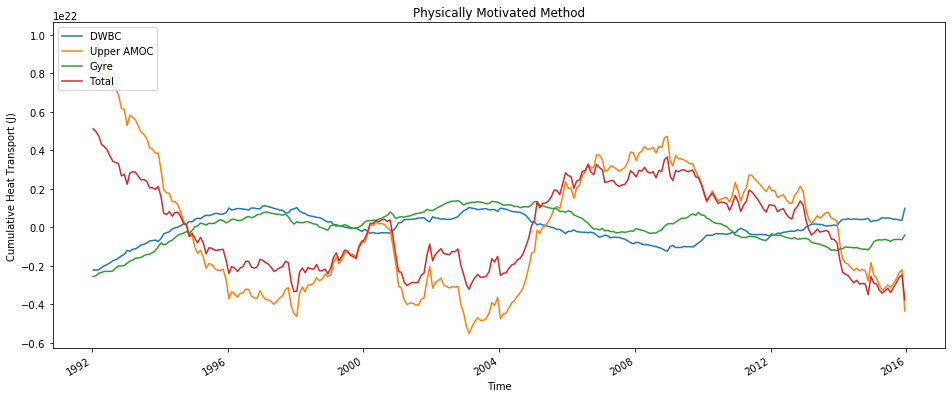

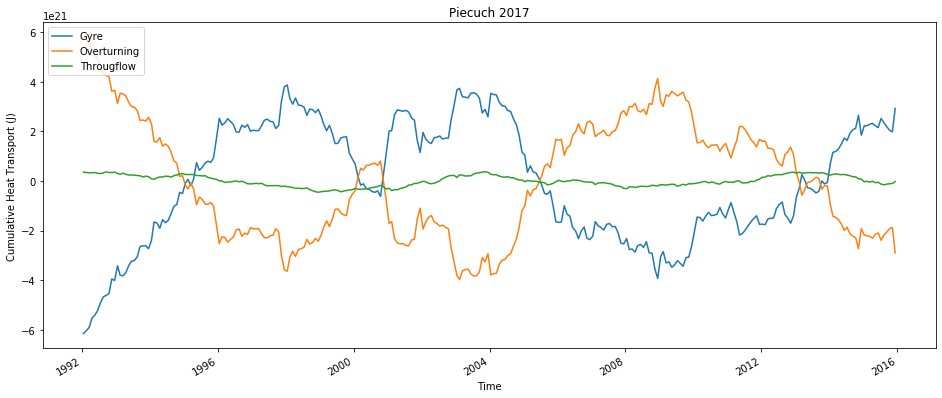

In [98]:
fig, ax = pltt.subplots(figsize=(16,6))
(bottom_ds).plot(ax=ax)
(left_ds).plot(ax=ax)
(right_ds).plot(ax=ax)
(net).plot(ax=ax)
ax.legend(("DWBC", "Upper AMOC", "Gyre", "Total"),loc='upper left')
pltt.ylabel('Cumulative Heat Transport (J)')
pltt.title('Physically Motivated Method')
fig, ax = pltt.subplots(figsize=(16,6))
(gyre_ds * rho0 * cp).plot(ax=ax)
(ov_ds* rho0 * cp).plot(ax=ax)
(tf_ds * rho0 * cp).plot(ax=ax)
ax.legend(("Gyre", "Overturning", "Througflow"),loc='upper left')
pltt.ylabel('Cumulative Heat Transport (J)')
pltt.title('Piecuch 2017')